In [ ]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

In [ ]:
!pip install -q catboost
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 7.7 MB/s eta 0:00:00


In [ ]:
import joblib
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

# Random Forest
rf_model = joblib.load("models/random_forest/random_forest.pkl")

# Target Encoder
tt = joblib.load("models/random_forest/target_encoder.pkl")

# CatBoost
cat_model = CatBoostRegressor()
cat_model.load_model("models/catboost/catboost.cbm")

# LightGBM
lgb_model = lgb.Booster(model_file="models/lightgbm/baseline_lightgbm.txt")

# XGBoost
xgb_model = xgb.Booster()
xgb_model.load_model("models/xgboost/xgboost.json")

In [ ]:

# Environment Setup - Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error

import os
from pathlib import Path
import gc

In [ ]:
# Set Project Root
os.chdir("/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform")
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [ ]:
# Load Feature-Engineered Data
DATA_DIR = Path("data/features")

train = pd.read_parquet(DATA_DIR / "train_features.parquet")

In [ ]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()


0

In [ ]:
# Data Handling and Sorting
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values(
    ['store_nbr', 'family', 'date']
).reset_index(drop=True)


In [ ]:
# Drop NaN values in Lag/Roll Features
lag_cols = [col for col in train.columns if "lag" in col or "roll" in col]
train = train.dropna(subset=lag_cols).reset_index(drop=True)

In [ ]:
# Define Target and Features
TARGET = 'sales_log'
y_true = train[TARGET]

In [ ]:
# Drop unnecessaary Columns
Drop_cols = ['id', 'date', 'sales', 'sales_log']

FEATURES = [col for col in train.columns if col not in Drop_cols]

X_true = train[FEATURES]

In [ ]:
# Categorical Features
CAT_COLS = train.select_dtypes(include='category').columns.tolist()

# Handling Categorical Features
X_true_te = tt.transform(X_true)


# RMSLE Evaluation Function
def rmsle(y_true, y_pred):
  y_true = np.expm1(y_true)
  y_pred = np.expm1(y_pred)
  y_pred = np.maximum(y_pred, 0)
  return np.sqrt(mean_squared_log_error(y_true, y_pred))


In [ ]:
# RF Validation Prediction
rf_valid_pred = rf_model.predict(X_true_te)

# XGB Validation prediction
xgb_valid_pred = xgb_model.predict(xgb.DMatrix(X_true_te))

# Prepare LightGBM Dataset
lgb_train = lgb.Dataset(X_true,
    label=y_true,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)
# LightGBM Validation Prediction
lgb_valid_pred = lgb_model.predict(
    X_true,
    num_iteration=lgb_model.best_iteration
)

# CatBoost Validation Prediction
cat_valid_pred = cat_model.predict(X_true)

In [ ]:
metrics = {

    "RandomForest": {
        "RMSLE": rmsle(y_true, rf_valid_pred),
        "MAE": mean_absolute_error(y_true, rf_valid_pred),
    },
    "XGBoost": {
        "RMSLE": rmsle(y_true, xgb_valid_pred),
        "MAE": mean_absolute_error(y_true, xgb_valid_pred),
    },
    "LightGBM": {
        "RMSLE": rmsle(y_true, lgb_valid_pred),
        "MAE": mean_absolute_error(y_true, lgb_valid_pred),
    },
    "CatBoost": {
        "RMSLE": rmsle(y_true, cat_valid_pred),
        "MAE": mean_absolute_error(y_true, cat_valid_pred),
    }
}

metrics_df = pd.DataFrame(metrics).T
metrics_df

,RMSLE,MAE
RandomForest,0.420985,0.248741
XGBoost,0.358644,0.215189
LightGBM,0.346664,0.209143
CatBoost,0.393336,0.236285


In [ ]:
# Optimize Weighted Averageing
from scipy.optimize import minimize

# Define objective for weight optimization
def objective(weights, predictions, y_true):
    # Ensure weights sum to 1
    weights = weights / np.sum(weights)
    y_ens = np.dot(predictions, weights)
    return rmsle(y_true, y_ens)

# Collect all validation predictions (ensure they are the same length)
all_preds = np.column_stack([rf_valid_pred, xgb_valid_pred, lgb_valid_pred, cat_valid_pred])

# Run optimization
init_guess = [0.25] * 4
bounds = [(0, 1)] * 4
res = minimize(objective, init_guess, args=(all_preds, y_true), bounds=bounds)

best_weights = res.x / np.sum(res.x)
y_weighted_avg = np.dot(all_preds, best_weights)
print(f"Optimal Weights: {best_weights}")


Optimal Weights: [0. 0. 1. 0.]


In [ ]:
# Full Stacking Ensembling
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Define meta-model
meta_model = RidgeCV()

# Stack base models using cross-validation to prevent overfitting
# Note: Since you already have validation predictions, you can also train
# the meta-model directly on 'all_preds' vs 'y_true'
meta_model.fit(all_preds, y_true)
y_stacked = meta_model.predict(all_preds)


In [ ]:
# Bias Correlaion
def apply_bias_correction(y_pred, y_true):
    # Calculate the global bias (residual sum)
    bias = np.mean(y_true) - np.mean(y_pred)
    # Apply correction and ensure no negative values for RMSLE
    return np.maximum(y_pred + bias, 0)

y_stacked_corrected = apply_bias_correction(y_stacked, y_true)


In [ ]:
#  Post-processing: Zero-Sales Handling
# Optimize the ZERO_THRESHOLD
thresholds = np.linspace(0, 1, 50)
best_t = 0
best_s = np.inf

for t in thresholds:
    temp_pred = np.where(y_stacked_corrected < t, 0, y_stacked_corrected)
    score = rmsle(y_true, temp_pred)
    if score < best_s:
        best_s = score
        best_t = t

# Apply final threshold
y_final_optimized = np.where(y_stacked_corrected < best_t, 0, y_stacked_corrected)
print(f"Optimal Zero-Threshold: {best_t}")


Optimal Zero-Threshold: 0.04081632653061224


In [ ]:
# Final verification
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error
import numpy as np

# Ensure no negative values exist (required for RMSLE)
y_final_valid = np.maximum(y_final_optimized, 0)

# Calculate Metrics
final_rmsle = root_mean_squared_log_error(y_true, y_final_valid)
final_mae = mean_absolute_error(y_true, y_final_valid)

print(f"Final Ensemble RMSLE: {final_rmsle:.6f}")
print(f"Final Ensemble MAE:   {final_mae:.6f}")


Final Ensemble RMSLE: 0.153896
Final Ensemble MAE:   0.204855


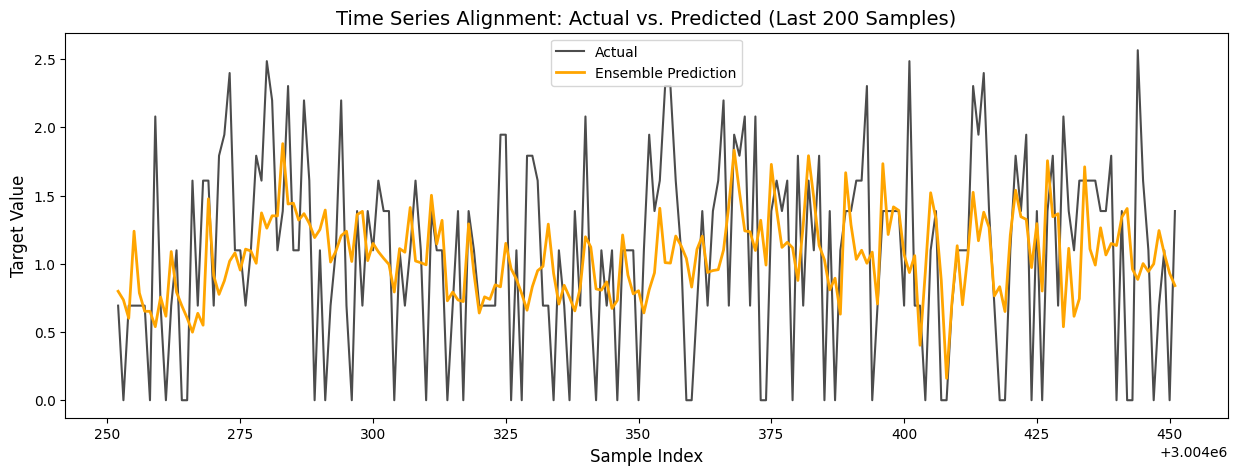

In [ ]:
# Select a window of samples to visualize (e.g., last 200)
window = 200
idx = np.arange(len(y_true))[-window:]

plt.figure(figsize=(15, 5))
plt.plot(idx, y_true[-window:], label='Actual', color='black', linewidth=1.5, alpha=0.7)
plt.plot(idx, y_final_optimized[-window:], label='Ensemble Prediction', color='orange', linewidth=2)

plt.title('Time Series Alignment: Actual vs. Predicted (Last 200 Samples)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend()
plt.show()
